# Userguide for the opern-source library SPFlow

SPFlow is an open-source functional-oriented Python package for Probabilistic Circuits (PCs) with ready-to-use implementations for Sum-Product Networks (SPNs). PCs are a class of powerful deep probabilistic models - expressible as directed acyclic graphs - that allow for tractable querying. This library provides routines for creating, learning, manipulating and interacting with PCs and is highly extensible and customizable.

## Create Toy Dataset

To demonstrate and visualize the main features of the library, we first create a 2D toy dataset with three Gaussian clusters, corresponding to labels 0, 1, and 2.
Each class contains 500 data points, for a total of 1,500 data points.

Dataset successfully created.
Shape of dataset: torch.Size([1500, 2])
Shape of labels: torch.Size([1500])
First 5 samples:
tensor([[ 3.1382, -2.8398],
        [ 0.6595,  2.8686],
        [ 0.8976,  3.0070],
        [ 3.6997, -1.7514],
        [ 3.7857, -2.9920]])
Corresponding labels:
tensor([2, 0, 0, 2, 2])


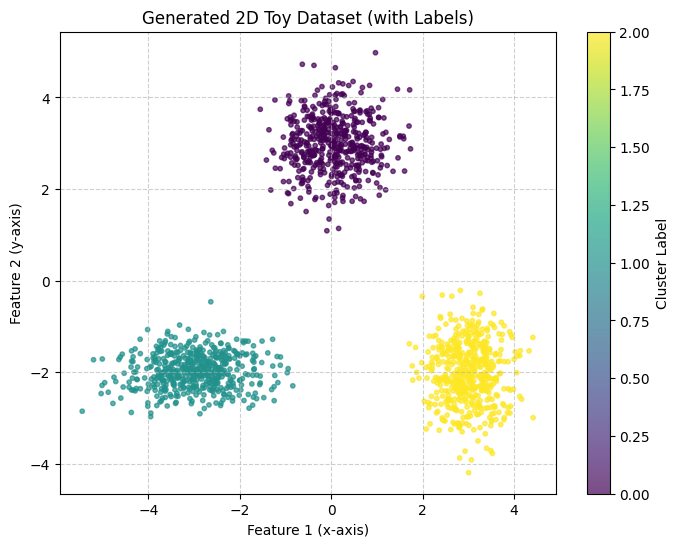

In [1]:
import torch
import matplotlib.pyplot as plt

# --- 1. Define the parameters for our dataset ---

n_points_per_cluster = 500

means = torch.tensor([
    [0.0, 3.0],   # Cluster 0
    [-3.0, -2.0], # Cluster 1
    [3.0, -2.0]   # Cluster 2
])

stds = torch.tensor([
    [0.6, 0.6],
    [0.8, 0.4],
    [0.5, 0.7]
])

# --- 2. Generate the data and labels ---

all_clusters = []
all_labels = []

for i in range(means.shape[0]):
    samples = (torch.randn(n_points_per_cluster, 2) * stds[i]) + means[i]
    labels = torch.full((n_points_per_cluster,), i, dtype=torch.long)  # label = cluster index
    all_clusters.append(samples)
    all_labels.append(labels)

# Concatenate all data and labels
dataset = torch.cat(all_clusters)
labels = torch.cat(all_labels)

# --- 3. Shuffle dataset and labels together ---

shuffled_indices = torch.randperm(dataset.shape[0])
dataset = dataset[shuffled_indices]
labels = labels[shuffled_indices]

# --- 4. Display some info ---

print("Dataset successfully created.")
print(f"Shape of dataset: {dataset.shape}")
print(f"Shape of labels: {labels.shape}")
print("First 5 samples:")
print(dataset[:5])
print("Corresponding labels:")
print(labels[:5])

# --- 5. Visualize the labeled dataset ---

data_np = dataset.cpu().numpy()
labels_np = labels.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(data_np[:, 0], data_np[:, 1], c=labels_np, cmap='viridis', s=10, alpha=0.7)
plt.title('Generated 2D Toy Dataset (with Labels)')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.colorbar(label='Cluster Label')
plt.show()



## Model Configuration
Below we manually create a simple Sum-Product Network by stacking leaf, product, and sum-layers

In [2]:
from spflow.modules.leaf import Normal
from spflow.modules import Sum
from spflow.modules import Product
from spflow.meta.data import Scope
from IPython.display import SVG, display

scope = Scope([0,1])

leaf_layer = Normal(scope=scope, out_channels=6)
product_layer = Product(inputs=leaf_layer)
spn = Sum(inputs=product_layer, out_channels=1)
spn

Sum(
  D=1, C=1, R=None, weights=(1, 6, 1)
  (inputs): Product(
    D=1, C=6, R=None
    (inputs): Normal(
      D=2, C=6, R=None
      (distribution): Normal()
    )
  )
)

Below is a visualization of the SPN defined above.
The number of output channels of a sum or leaf layer is equivalent to the number of nodes in that layer.
The number of nodes in a product layer is derived from the number of nodes in its input.

In [3]:
display(SVG(filename='StandardSPN.svg'))

Next, we can train the SPN, for example, using gradient descent.
The library already provides a method for training an SPN with gradient descent.
To do this, simply pass your training parameters such as the number of epochs, learning rate, etc.

In [4]:
from spflow.learn import train_gradient_descent
from torch.utils.data import DataLoader, TensorDataset
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

train_dataset = TensorDataset(dataset)
dataloader = DataLoader(train_dataset, batch_size=10)
train_gradient_descent(spn, dataloader, epochs=10, lr=0.1, verbose=True)

2025-10-22 15:31:06,001 [INFO] spflow.learn.gradient_descent: Epoch [0/10]: Loss: 28.3584041595459


Time taken for epoch:  0.43099522590637207


2025-10-22 15:31:06,389 [INFO] spflow.learn.gradient_descent: Epoch [1/10]: Loss: 25.652482986450195


Time taken for epoch:  0.38700413703918457


2025-10-22 15:31:06,763 [INFO] spflow.learn.gradient_descent: Epoch [2/10]: Loss: 25.282752990722656


Time taken for epoch:  0.37200188636779785


2025-10-22 15:31:07,142 [INFO] spflow.learn.gradient_descent: Epoch [3/10]: Loss: 25.147560119628906


Time taken for epoch:  0.3780021667480469


2025-10-22 15:31:07,521 [INFO] spflow.learn.gradient_descent: Epoch [4/10]: Loss: 25.094987869262695


Time taken for epoch:  0.3770015239715576


2025-10-22 15:31:07,899 [INFO] spflow.learn.gradient_descent: Epoch [5/10]: Loss: 24.57073211669922


Time taken for epoch:  0.37599825859069824


2025-10-22 15:31:08,291 [INFO] spflow.learn.gradient_descent: Epoch [6/10]: Loss: 24.563499450683594


Time taken for epoch:  0.3900015354156494


2025-10-22 15:31:08,689 [INFO] spflow.learn.gradient_descent: Epoch [7/10]: Loss: 24.5408878326416


Time taken for epoch:  0.39699888229370117


2025-10-22 15:31:09,071 [INFO] spflow.learn.gradient_descent: Epoch [8/10]: Loss: 24.54788589477539


Time taken for epoch:  0.3789968490600586


2025-10-22 15:31:09,490 [INFO] spflow.learn.gradient_descent: Epoch [9/10]: Loss: 24.552001953125


Time taken for epoch:  0.4180026054382324


Once the SPN is trained, we can perform queries such as inference and sampling.
SPFlow uses internal dispatching so that a single query function can work across all module types.
For example, the log_likelihood method shown below can be used for every SPN model encountered throughout this guide.

In [5]:
from spflow import log_likelihood

ll = log_likelihood(spn, dataset)
ll

tensor([[[-2.6105]],

        [[-2.4889]],

        [[-2.9082]],

        ...,

        [[-1.9774]],

        [[-2.1911]],

        [[-2.7200]]], grad_fn=<ViewBackward0>)

Finally, we can visualize the training results on our toy dataset.

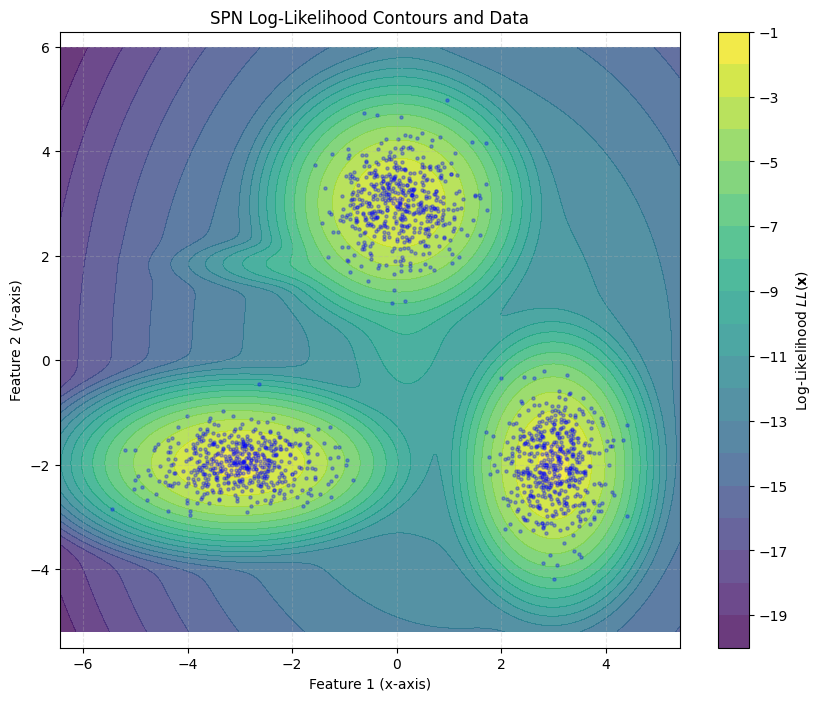

In [6]:
import numpy as np
data_np = dataset.cpu().numpy()

# Define the boundaries of the plot with a small padding
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

# Create a grid of points
grid_resolution = 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                     np.linspace(y_min, y_max, grid_resolution))

# Stack the grid points into a format our function can accept: [n_points, 2]
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
ll = log_likelihood(spn, grid_points)
# Reshape the LL values to match the grid shape for plotting
Z = ll.detach().cpu().numpy().reshape(xx.shape)


# --- 6. Visualize the Data and Log-Likelihood Contours ---

plt.figure(figsize=(10, 8))

# Plot the filled contour map of the log-likelihood
# Higher values (brighter colors) mean the model thinks data is more likely there
contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)

# Add a color bar to show the LL scale
plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')

# Overlay the scatter plot of the actual data points
# We make them semi-transparent and small to see the density and contours
plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')

# Add titles and labels
plt.title('SPN Log-Likelihood Contours and Data')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.show()


## Automatic Model creation
Besides creating an SPN manually by stacking layers, it is also possible to use algorithms to automatically construct the SPN architecture.

###  Rat-SPN
The Rat-SPN algorithm builds a deep network structure by recursively partitioning the features (variables) into random subsets and alternating between sum and product layers.
Below, we set up a Rat-SPN by defining its structure and parameters.

In [7]:
from spflow.modules.rat.rat_spn import RatSPN
depth = 1
n_region_nodes = 3
num_leaves = 2
num_repetitions = 2
n_root_nodes = 1
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
rat

RatSPN(
  D=1, C=1, R=2
  (root_node): MixingLayer(
    D=1, C=1, R=2, weights=(1, 2, 1)
    (inputs): Sum(
      D=1, C=1, R=2, weights=(1, 4, 1, 2)
      (inputs): OuterProduct(
        D=1, C=4, R=2
        (inputs): ModuleList(
          (0): SplitHalves(
            D=2, C=2, R=2, dim=1
            (inputs): ModuleList(
              (0): Factorize(
                D=2, C=2, R=2
                (inputs): ModuleList(
                  (0): Normal(
                    D=2, C=2, R=2
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)

Here is a visualization of the architecture we just created.

In [8]:
display(SVG(filename='Rat_SPN.svg'))

In [9]:
ll = log_likelihood(rat, dataset)
ll

tensor([[[-60.3814]],

        [[-25.6382]],

        [[-29.0291]],

        ...,

        [[-51.9250]],

        [[-55.5292]],

        [[-23.8584]]], grad_fn=<ViewBackward0>)

We can again train this model using the provided gradient descent method.

In [10]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

Time taken for epoch:  0.5650033950805664
Time taken for epoch:  0.534991979598999
Time taken for epoch:  0.5310049057006836
Time taken for epoch:  0.5419998168945312
Time taken for epoch:  0.5440070629119873
Time taken for epoch:  0.5639946460723877
Time taken for epoch:  0.5509974956512451
Time taken for epoch:  0.5600030422210693
Time taken for epoch:  0.5670053958892822
Time taken for epoch:  0.538994312286377
Time taken for epoch:  0.5479991436004639
Time taken for epoch:  0.5630018711090088
Time taken for epoch:  0.5540001392364502
Time taken for epoch:  0.5779986381530762
Time taken for epoch:  0.5740053653717041
Time taken for epoch:  0.5849988460540771
Time taken for epoch:  0.5650055408477783
Time taken for epoch:  0.5269911289215088
Time taken for epoch:  0.5499939918518066
Time taken for epoch:  0.5750010013580322


o verify that the training worked properly, we can visualize the log-likelihoods of the trained model.

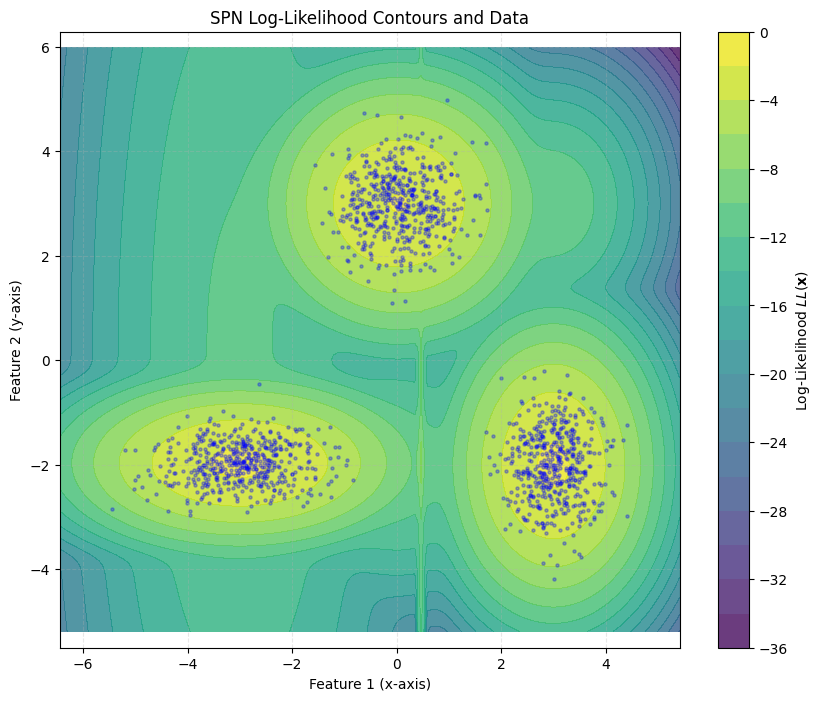

In [11]:
import numpy as np
data_np = dataset.cpu().numpy()

# Define the boundaries of the plot with a small padding
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

# Create a grid of points
grid_resolution = 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                     np.linspace(y_min, y_max, grid_resolution))

# Stack the grid points into a format our function can accept: [n_points, 2]
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
ll = log_likelihood(rat, grid_points)
# Reshape the LL values to match the grid shape for plotting
Z = ll.detach().cpu().numpy().reshape(xx.shape)


# --- 6. Visualize the Data and Log-Likelihood Contours ---

plt.figure(figsize=(10, 8))

# Plot the filled contour map of the log-likelihood
# Higher values (brighter colors) mean the model thinks data is more likely there
contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)

# Add a color bar to show the LL scale
plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')

# Overlay the scatter plot of the actual data points
# We make them semi-transparent and small to see the density and contours
plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')

# Add titles and labels
plt.title('SPN Log-Likelihood Contours and Data')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.show()

Of course, computing log-likelihoods is not the only thing the model can do.
Below is a visualization of samples drawn from the trained Rat-SPN.

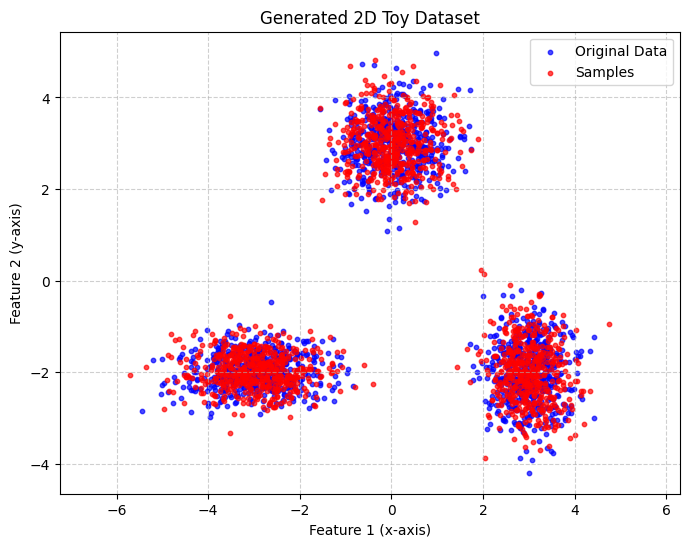

In [12]:
from spflow import sample

samples = sample(spn, 1500)

plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c='red', label='Samples')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()


Up to now, we have focused only on generation, without considering the labels of the training instances.
Next, we will train a second Rat-SPN for classification.

In [13]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

depth = 1
n_region_nodes = 1
num_leaves = 10
num_repetitions = 1
n_root_nodes = 3
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
train_dataset = TensorDataset(dataset, labels)
dataloader_with_labels = DataLoader(train_dataset, batch_size=10)

train_gradient_descent(rat.root_node.inputs, dataloader_with_labels, epochs=100, lr=0.001, is_classification=True, verbose=True)



2025-10-22 15:31:23,094 [INFO] spflow.learn.gradient_descent: Epoch [0/100]: Loss: 8.034124374389648


Time taken for epoch:  0.6759939193725586
Accuracy: 21.133333333333333


2025-10-22 15:31:23,754 [INFO] spflow.learn.gradient_descent: Epoch [1/100]: Loss: 6.979676723480225


Time taken for epoch:  0.6589999198913574
Accuracy: 67.13333333333334


2025-10-22 15:31:24,417 [INFO] spflow.learn.gradient_descent: Epoch [2/100]: Loss: 6.168992519378662


Time taken for epoch:  0.6609981060028076
Accuracy: 94.26666666666667


2025-10-22 15:31:25,046 [INFO] spflow.learn.gradient_descent: Epoch [3/100]: Loss: 5.557310581207275


Time taken for epoch:  0.6270003318786621
Accuracy: 97.06666666666666


2025-10-22 15:31:25,620 [INFO] spflow.learn.gradient_descent: Epoch [4/100]: Loss: 5.109541893005371


Time taken for epoch:  0.5730018615722656
Accuracy: 98.26666666666667


2025-10-22 15:31:26,162 [INFO] spflow.learn.gradient_descent: Epoch [5/100]: Loss: 4.74855899810791


Time taken for epoch:  0.5389974117279053
Accuracy: 99.8


2025-10-22 15:31:26,676 [INFO] spflow.learn.gradient_descent: Epoch [6/100]: Loss: 4.41995906829834


Time taken for epoch:  0.51300048828125
Accuracy: 99.86666666666666


2025-10-22 15:31:27,166 [INFO] spflow.learn.gradient_descent: Epoch [7/100]: Loss: 4.121767520904541


Time taken for epoch:  0.48799800872802734
Accuracy: 99.86666666666666


2025-10-22 15:31:27,629 [INFO] spflow.learn.gradient_descent: Epoch [8/100]: Loss: 3.8483664989471436


Time taken for epoch:  0.46300268173217773
Accuracy: 99.93333333333334


2025-10-22 15:31:28,074 [INFO] spflow.learn.gradient_descent: Epoch [9/100]: Loss: 3.5871880054473877


Time taken for epoch:  0.44300174713134766
Accuracy: 99.93333333333334


2025-10-22 15:31:28,471 [INFO] spflow.learn.gradient_descent: Epoch [10/100]: Loss: 3.344357967376709


Time taken for epoch:  0.3959968090057373
Accuracy: 99.93333333333334


2025-10-22 15:31:28,823 [INFO] spflow.learn.gradient_descent: Epoch [11/100]: Loss: 3.1286404132843018


Time taken for epoch:  0.350996732711792
Accuracy: 99.93333333333334


2025-10-22 15:31:29,176 [INFO] spflow.learn.gradient_descent: Epoch [12/100]: Loss: 2.9401750564575195


Time taken for epoch:  0.3520028591156006
Accuracy: 100.0


2025-10-22 15:31:29,530 [INFO] spflow.learn.gradient_descent: Epoch [13/100]: Loss: 2.773951530456543


Time taken for epoch:  0.3529980182647705
Accuracy: 100.0


2025-10-22 15:31:29,877 [INFO] spflow.learn.gradient_descent: Epoch [14/100]: Loss: 2.6237075328826904


Time taken for epoch:  0.3450002670288086
Accuracy: 100.0


2025-10-22 15:31:30,224 [INFO] spflow.learn.gradient_descent: Epoch [15/100]: Loss: 2.484323740005493


Time taken for epoch:  0.3470008373260498
Accuracy: 100.0


2025-10-22 15:31:30,571 [INFO] spflow.learn.gradient_descent: Epoch [16/100]: Loss: 2.352832078933716


Time taken for epoch:  0.34600067138671875
Accuracy: 100.0


2025-10-22 15:31:30,935 [INFO] spflow.learn.gradient_descent: Epoch [17/100]: Loss: 2.228148937225342


Time taken for epoch:  0.36099720001220703
Accuracy: 100.0


2025-10-22 15:31:31,307 [INFO] spflow.learn.gradient_descent: Epoch [18/100]: Loss: 2.1104073524475098


Time taken for epoch:  0.3710005283355713
Accuracy: 100.0


2025-10-22 15:31:31,662 [INFO] spflow.learn.gradient_descent: Epoch [19/100]: Loss: 2.000605821609497


Time taken for epoch:  0.3529999256134033
Accuracy: 100.0


2025-10-22 15:31:32,011 [INFO] spflow.learn.gradient_descent: Epoch [20/100]: Loss: 1.9006551504135132


Time taken for epoch:  0.34800004959106445
Accuracy: 100.0


2025-10-22 15:31:32,359 [INFO] spflow.learn.gradient_descent: Epoch [21/100]: Loss: 1.8130054473876953


Time taken for epoch:  0.3470001220703125
Accuracy: 100.0


2025-10-22 15:31:32,711 [INFO] spflow.learn.gradient_descent: Epoch [22/100]: Loss: 1.739304542541504


Time taken for epoch:  0.3509974479675293
Accuracy: 100.0


2025-10-22 15:31:33,064 [INFO] spflow.learn.gradient_descent: Epoch [23/100]: Loss: 1.6792415380477905


Time taken for epoch:  0.3520028591156006
Accuracy: 100.0


2025-10-22 15:31:33,414 [INFO] spflow.learn.gradient_descent: Epoch [24/100]: Loss: 1.6310094594955444


Time taken for epoch:  0.34799742698669434
Accuracy: 100.0


2025-10-22 15:31:33,757 [INFO] spflow.learn.gradient_descent: Epoch [25/100]: Loss: 1.5925071239471436


Time taken for epoch:  0.34200119972229004
Accuracy: 100.0


2025-10-22 15:31:34,102 [INFO] spflow.learn.gradient_descent: Epoch [26/100]: Loss: 1.5618704557418823


Time taken for epoch:  0.3449997901916504
Accuracy: 100.0


2025-10-22 15:31:34,450 [INFO] spflow.learn.gradient_descent: Epoch [27/100]: Loss: 1.5374752283096313


Time taken for epoch:  0.3469974994659424
Accuracy: 100.0


2025-10-22 15:31:34,796 [INFO] spflow.learn.gradient_descent: Epoch [28/100]: Loss: 1.5179252624511719


Time taken for epoch:  0.3450002670288086
Accuracy: 100.0


2025-10-22 15:31:35,159 [INFO] spflow.learn.gradient_descent: Epoch [29/100]: Loss: 1.5020759105682373


Time taken for epoch:  0.36100292205810547
Accuracy: 100.0


2025-10-22 15:31:35,520 [INFO] spflow.learn.gradient_descent: Epoch [30/100]: Loss: 1.4890352487564087


Time taken for epoch:  0.36100172996520996
Accuracy: 100.0


2025-10-22 15:31:35,908 [INFO] spflow.learn.gradient_descent: Epoch [31/100]: Loss: 1.4781330823898315


Time taken for epoch:  0.38699960708618164
Accuracy: 100.0


2025-10-22 15:31:36,261 [INFO] spflow.learn.gradient_descent: Epoch [32/100]: Loss: 1.4688801765441895


Time taken for epoch:  0.3509998321533203
Accuracy: 100.0


2025-10-22 15:31:36,609 [INFO] spflow.learn.gradient_descent: Epoch [33/100]: Loss: 1.4609177112579346


Time taken for epoch:  0.34800100326538086
Accuracy: 100.0


2025-10-22 15:31:36,952 [INFO] spflow.learn.gradient_descent: Epoch [34/100]: Loss: 1.453984260559082


Time taken for epoch:  0.3409998416900635
Accuracy: 100.0


2025-10-22 15:31:37,310 [INFO] spflow.learn.gradient_descent: Epoch [35/100]: Loss: 1.4478862285614014


Time taken for epoch:  0.35700035095214844
Accuracy: 100.0


2025-10-22 15:31:37,662 [INFO] spflow.learn.gradient_descent: Epoch [36/100]: Loss: 1.4424793720245361


Time taken for epoch:  0.35199999809265137
Accuracy: 100.0


2025-10-22 15:31:38,010 [INFO] spflow.learn.gradient_descent: Epoch [37/100]: Loss: 1.4376550912857056


Time taken for epoch:  0.3470005989074707
Accuracy: 100.0


2025-10-22 15:31:38,361 [INFO] spflow.learn.gradient_descent: Epoch [38/100]: Loss: 1.4333276748657227


Time taken for epoch:  0.34999990463256836
Accuracy: 100.0


2025-10-22 15:31:38,714 [INFO] spflow.learn.gradient_descent: Epoch [39/100]: Loss: 1.4294286966323853


Time taken for epoch:  0.35199999809265137
Accuracy: 100.0


2025-10-22 15:31:39,066 [INFO] spflow.learn.gradient_descent: Epoch [40/100]: Loss: 1.425904631614685


Time taken for epoch:  0.35000014305114746
Accuracy: 100.0


2025-10-22 15:31:39,415 [INFO] spflow.learn.gradient_descent: Epoch [41/100]: Loss: 1.42271089553833


Time taken for epoch:  0.34800004959106445
Accuracy: 100.0


2025-10-22 15:31:39,764 [INFO] spflow.learn.gradient_descent: Epoch [42/100]: Loss: 1.4198110103607178


Time taken for epoch:  0.34800004959106445
Accuracy: 100.0


2025-10-22 15:31:40,112 [INFO] spflow.learn.gradient_descent: Epoch [43/100]: Loss: 1.4171727895736694


Time taken for epoch:  0.34599995613098145
Accuracy: 100.0


2025-10-22 15:31:40,460 [INFO] spflow.learn.gradient_descent: Epoch [44/100]: Loss: 1.4147694110870361


Time taken for epoch:  0.34600114822387695
Accuracy: 100.0


2025-10-22 15:31:40,809 [INFO] spflow.learn.gradient_descent: Epoch [45/100]: Loss: 1.4125761985778809


Time taken for epoch:  0.3489995002746582
Accuracy: 100.0


2025-10-22 15:31:41,157 [INFO] spflow.learn.gradient_descent: Epoch [46/100]: Loss: 1.4105737209320068


Time taken for epoch:  0.34600043296813965
Accuracy: 100.0


2025-10-22 15:31:41,510 [INFO] spflow.learn.gradient_descent: Epoch [47/100]: Loss: 1.4087425470352173


Time taken for epoch:  0.35199689865112305
Accuracy: 100.0


2025-10-22 15:31:41,852 [INFO] spflow.learn.gradient_descent: Epoch [48/100]: Loss: 1.4070671796798706


Time taken for epoch:  0.3409996032714844
Accuracy: 100.0


2025-10-22 15:31:42,203 [INFO] spflow.learn.gradient_descent: Epoch [49/100]: Loss: 1.4055334329605103


Time taken for epoch:  0.3489992618560791
Accuracy: 100.0


2025-10-22 15:31:42,548 [INFO] spflow.learn.gradient_descent: Epoch [50/100]: Loss: 1.4046827554702759


Time taken for epoch:  0.3439981937408447
Accuracy: 100.0


2025-10-22 15:31:42,893 [INFO] spflow.learn.gradient_descent: Epoch [51/100]: Loss: 1.4044160842895508


Time taken for epoch:  0.34400272369384766
Accuracy: 100.0


2025-10-22 15:31:43,245 [INFO] spflow.learn.gradient_descent: Epoch [52/100]: Loss: 1.404148817062378


Time taken for epoch:  0.3510003089904785
Accuracy: 100.0


2025-10-22 15:31:43,593 [INFO] spflow.learn.gradient_descent: Epoch [53/100]: Loss: 1.4038811922073364


Time taken for epoch:  0.34599876403808594
Accuracy: 100.0


2025-10-22 15:31:43,941 [INFO] spflow.learn.gradient_descent: Epoch [54/100]: Loss: 1.403611183166504


Time taken for epoch:  0.3470001220703125
Accuracy: 100.0


2025-10-22 15:31:44,292 [INFO] spflow.learn.gradient_descent: Epoch [55/100]: Loss: 1.4033403396606445


Time taken for epoch:  0.3490011692047119
Accuracy: 100.0


2025-10-22 15:31:44,639 [INFO] spflow.learn.gradient_descent: Epoch [56/100]: Loss: 1.4030680656433105


Time taken for epoch:  0.3449993133544922
Accuracy: 100.0


2025-10-22 15:31:44,985 [INFO] spflow.learn.gradient_descent: Epoch [57/100]: Loss: 1.402795433998108


Time taken for epoch:  0.3449985980987549
Accuracy: 100.0


2025-10-22 15:31:45,335 [INFO] spflow.learn.gradient_descent: Epoch [58/100]: Loss: 1.4025218486785889


Time taken for epoch:  0.3490004539489746
Accuracy: 100.0


2025-10-22 15:31:45,685 [INFO] spflow.learn.gradient_descent: Epoch [59/100]: Loss: 1.4022490978240967


Time taken for epoch:  0.34800267219543457
Accuracy: 100.0


2025-10-22 15:31:46,037 [INFO] spflow.learn.gradient_descent: Epoch [60/100]: Loss: 1.4019755125045776


Time taken for epoch:  0.35199880599975586
Accuracy: 100.0


2025-10-22 15:31:46,407 [INFO] spflow.learn.gradient_descent: Epoch [61/100]: Loss: 1.401702642440796


Time taken for epoch:  0.3679990768432617
Accuracy: 100.0


2025-10-22 15:31:46,756 [INFO] spflow.learn.gradient_descent: Epoch [62/100]: Loss: 1.4014283418655396


Time taken for epoch:  0.3470008373260498
Accuracy: 100.0


2025-10-22 15:31:47,097 [INFO] spflow.learn.gradient_descent: Epoch [63/100]: Loss: 1.40115487575531


Time taken for epoch:  0.34099864959716797
Accuracy: 100.0


2025-10-22 15:31:47,447 [INFO] spflow.learn.gradient_descent: Epoch [64/100]: Loss: 1.4008824825286865


Time taken for epoch:  0.3489997386932373
Accuracy: 100.0


2025-10-22 15:31:47,795 [INFO] spflow.learn.gradient_descent: Epoch [65/100]: Loss: 1.400610327720642


Time taken for epoch:  0.3470005989074707
Accuracy: 100.0


2025-10-22 15:31:48,140 [INFO] spflow.learn.gradient_descent: Epoch [66/100]: Loss: 1.400338888168335


Time taken for epoch:  0.34400033950805664
Accuracy: 100.0


2025-10-22 15:31:48,487 [INFO] spflow.learn.gradient_descent: Epoch [67/100]: Loss: 1.4000680446624756


Time taken for epoch:  0.34599971771240234
Accuracy: 100.0


2025-10-22 15:31:48,828 [INFO] spflow.learn.gradient_descent: Epoch [68/100]: Loss: 1.3997986316680908


Time taken for epoch:  0.33899950981140137
Accuracy: 100.0


2025-10-22 15:31:49,179 [INFO] spflow.learn.gradient_descent: Epoch [69/100]: Loss: 1.3995317220687866


Time taken for epoch:  0.35000061988830566
Accuracy: 100.0


2025-10-22 15:31:49,529 [INFO] spflow.learn.gradient_descent: Epoch [70/100]: Loss: 1.3992669582366943


Time taken for epoch:  0.3489992618560791
Accuracy: 100.0


2025-10-22 15:31:49,879 [INFO] spflow.learn.gradient_descent: Epoch [71/100]: Loss: 1.3990039825439453


Time taken for epoch:  0.3490006923675537
Accuracy: 100.0


2025-10-22 15:31:50,228 [INFO] spflow.learn.gradient_descent: Epoch [72/100]: Loss: 1.3987451791763306


Time taken for epoch:  0.3469984531402588
Accuracy: 100.0


2025-10-22 15:31:50,576 [INFO] spflow.learn.gradient_descent: Epoch [73/100]: Loss: 1.3984895944595337


Time taken for epoch:  0.3470001220703125
Accuracy: 100.0


2025-10-22 15:31:50,926 [INFO] spflow.learn.gradient_descent: Epoch [74/100]: Loss: 1.3982372283935547


Time taken for epoch:  0.3490023612976074
Accuracy: 100.0


2025-10-22 15:31:51,273 [INFO] spflow.learn.gradient_descent: Epoch [75/100]: Loss: 1.3981529474258423


Time taken for epoch:  0.34599804878234863
Accuracy: 100.0


2025-10-22 15:31:51,623 [INFO] spflow.learn.gradient_descent: Epoch [76/100]: Loss: 1.3981263637542725


Time taken for epoch:  0.3490002155303955
Accuracy: 100.0


2025-10-22 15:31:51,974 [INFO] spflow.learn.gradient_descent: Epoch [77/100]: Loss: 1.3980995416641235


Time taken for epoch:  0.34999966621398926
Accuracy: 100.0


2025-10-22 15:31:52,323 [INFO] spflow.learn.gradient_descent: Epoch [78/100]: Loss: 1.398072361946106


Time taken for epoch:  0.34799957275390625
Accuracy: 100.0


2025-10-22 15:31:52,672 [INFO] spflow.learn.gradient_descent: Epoch [79/100]: Loss: 1.3980449438095093


Time taken for epoch:  0.3469996452331543
Accuracy: 100.0


2025-10-22 15:31:53,024 [INFO] spflow.learn.gradient_descent: Epoch [80/100]: Loss: 1.3980177640914917


Time taken for epoch:  0.35100221633911133
Accuracy: 100.0


2025-10-22 15:31:53,377 [INFO] spflow.learn.gradient_descent: Epoch [81/100]: Loss: 1.3979898691177368


Time taken for epoch:  0.3509998321533203
Accuracy: 100.0


2025-10-22 15:31:53,740 [INFO] spflow.learn.gradient_descent: Epoch [82/100]: Loss: 1.397961974143982


Time taken for epoch:  0.36299872398376465
Accuracy: 100.0


2025-10-22 15:31:54,087 [INFO] spflow.learn.gradient_descent: Epoch [83/100]: Loss: 1.397933840751648


Time taken for epoch:  0.3460042476654053
Accuracy: 100.0


2025-10-22 15:31:54,441 [INFO] spflow.learn.gradient_descent: Epoch [84/100]: Loss: 1.397905707359314


Time taken for epoch:  0.3529984951019287
Accuracy: 100.0


2025-10-22 15:31:54,788 [INFO] spflow.learn.gradient_descent: Epoch [85/100]: Loss: 1.3978776931762695


Time taken for epoch:  0.34600067138671875
Accuracy: 100.0


2025-10-22 15:31:55,138 [INFO] spflow.learn.gradient_descent: Epoch [86/100]: Loss: 1.3978493213653564


Time taken for epoch:  0.34799671173095703
Accuracy: 100.0


2025-10-22 15:31:55,493 [INFO] spflow.learn.gradient_descent: Epoch [87/100]: Loss: 1.3978211879730225


Time taken for epoch:  0.35399937629699707
Accuracy: 100.0


2025-10-22 15:31:55,844 [INFO] spflow.learn.gradient_descent: Epoch [88/100]: Loss: 1.3977928161621094


Time taken for epoch:  0.3510000705718994
Accuracy: 100.0


2025-10-22 15:31:56,191 [INFO] spflow.learn.gradient_descent: Epoch [89/100]: Loss: 1.3977644443511963


Time taken for epoch:  0.34600043296813965
Accuracy: 100.0


2025-10-22 15:31:56,540 [INFO] spflow.learn.gradient_descent: Epoch [90/100]: Loss: 1.3977363109588623


Time taken for epoch:  0.34800004959106445
Accuracy: 100.0


2025-10-22 15:31:56,892 [INFO] spflow.learn.gradient_descent: Epoch [91/100]: Loss: 1.3977079391479492


Time taken for epoch:  0.3509981632232666
Accuracy: 100.0


2025-10-22 15:31:57,236 [INFO] spflow.learn.gradient_descent: Epoch [92/100]: Loss: 1.397679090499878


Time taken for epoch:  0.3430004119873047
Accuracy: 100.0


2025-10-22 15:31:57,598 [INFO] spflow.learn.gradient_descent: Epoch [93/100]: Loss: 1.3976510763168335


Time taken for epoch:  0.3540000915527344
Accuracy: 100.0


2025-10-22 15:31:57,949 [INFO] spflow.learn.gradient_descent: Epoch [94/100]: Loss: 1.39762282371521


Time taken for epoch:  0.3489971160888672
Accuracy: 100.0


2025-10-22 15:31:58,292 [INFO] spflow.learn.gradient_descent: Epoch [95/100]: Loss: 1.3975944519042969


Time taken for epoch:  0.3410005569458008
Accuracy: 100.0


2025-10-22 15:31:58,637 [INFO] spflow.learn.gradient_descent: Epoch [96/100]: Loss: 1.3975660800933838


Time taken for epoch:  0.3429996967315674
Accuracy: 100.0


2025-10-22 15:31:58,979 [INFO] spflow.learn.gradient_descent: Epoch [97/100]: Loss: 1.3975379467010498


Time taken for epoch:  0.3410003185272217
Accuracy: 100.0


2025-10-22 15:31:59,326 [INFO] spflow.learn.gradient_descent: Epoch [98/100]: Loss: 1.3975095748901367


Time taken for epoch:  0.3450002670288086
Accuracy: 100.0


2025-10-22 15:31:59,675 [INFO] spflow.learn.gradient_descent: Epoch [99/100]: Loss: 1.3974813222885132


Time taken for epoch:  0.3489978313446045
Accuracy: 100.0


With this SPN, we can now draw samples based on its labels. 

Repetition idx: torch.Size([500, 1])
Samples shape before gather: torch.Size([500, 2, 10, 1])
Repetition idx: torch.Size([500, 1])
Samples shape before gather: torch.Size([500, 2, 10, 1])
Repetition idx: torch.Size([500, 1])
Samples shape before gather: torch.Size([500, 2, 10, 1])


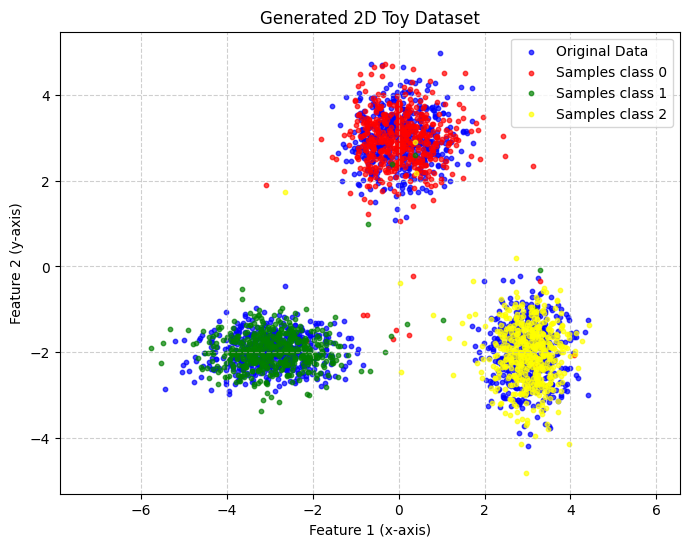

In [14]:
from spflow.meta.dispatch import SamplingContext

n_samples = 500
out_features = rat.out_features
num_features = 2

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 0, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class0 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 1, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class1 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 2, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class2 = sample(rat, evidence, sampling_ctx=sampling_ctx)


plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples_class0[:, 0], samples_class0[:, 1], s=10, alpha=0.7, c='red', label='Samples class 0')
plt.scatter(samples_class1[:, 0], samples_class1[:, 1], s=10, alpha=0.7, c='green', label='Samples class 1')
plt.scatter(samples_class2[:, 0], samples_class2[:, 1], s=10, alpha=0.7, c='yellow', label='Samples class 2')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()

However, the model can of course also be used for classification. As an example, we visualize the trained decision boundaries of our model

torch.Size([90000, 1, 3])
tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])


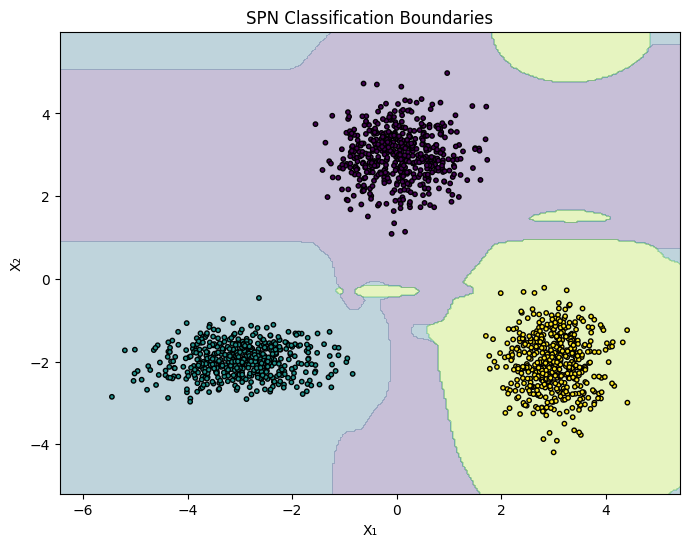

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Assuming your dataset and labels are already created as above ---

# Let's assume you have an SPN model trained on this data:
# For example:
# spn = MySPNModel()
# spn.fit(dataset, labels)

# --- 1. Create a grid of points over the feature space ---
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 300),
    torch.linspace(y_min, y_max, 300),
    indexing='xy'
)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# --- 2. Get SPN predictions (probabilities or class scores) ---
# Example: if your SPN returns class probabilities
with torch.no_grad():
    probs = log_likelihood(rat.root_node.inputs, grid_points) # shape: [N_grid, num_classes]
    print(probs.shape)
    preds = probs.argmax(dim=-1)
    print(preds)

# --- 3. Reshape predictions to match the grid ---
Z = preds.reshape(xx.shape)

# --- 4. Plot decision boundaries ---
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=len(means), cmap="viridis")

# Plot the original data
plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap="viridis", s=10, edgecolor="k")

plt.title("SPN Classification Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.show()


## LearnSPN
Instead of creating a random structure, we can also train the SPN structure using the LearnSPN. 

In [16]:
from spflow.learn.learn_spn import learn_spn
scope = Scope(list(range(2)))
normal_layer = Normal(scope=scope, out_channels=4)
learn_spn = learn_spn(
    torch.tensor(dataset, dtype=torch.float32),
    leaf_modules=normal_layer,
    out_channels=1,
    min_instances_slice=70,
    min_features_slice = 2
)
learn_spn

used 3 iterations (0.009s) to cluster 1500 items into 2 clusters
used 2 iterations (0.002s) to cluster 1000 items into 2 clusters


C:\Users\alex_\AppData\Local\Temp\ipykernel_29228\3209010222.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dataset, dtype=torch.float32),
F:\Pycharm\PycharmProjects\SPFlowTorch\spflow\learn\learn_spn.py:366: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  weights = torch.tensor(w).T.unsqueeze(0).unsqueeze(-1)  # shape(1, num_clusters, 1)


Sum(
  D=1, C=1, R=None, weights=(1, 5, 1)
  (inputs): Cat(
    D=1, C=5, R=None, dim=2
    (inputs): ModuleList(
      (0): Product(
        D=1, C=4, R=None
        (inputs): Cat(
          D=2, C=4, R=None, dim=1
          (inputs): ModuleList(
            (0-1): 2 x Normal(
              D=1, C=4, R=None
              (distribution): Normal()
            )
          )
        )
      )
      (1): Sum(
        D=1, C=1, R=None, weights=(1, 8, 1)
        (inputs): Cat(
          D=1, C=8, R=None, dim=2
          (inputs): ModuleList(
            (0-1): 2 x Product(
              D=1, C=4, R=None
              (inputs): Cat(
                D=2, C=4, R=None, dim=1
                (inputs): ModuleList(
                  (0-1): 2 x Normal(
                    D=1, C=4, R=None
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)

The trained SPN can now be used just like any other module

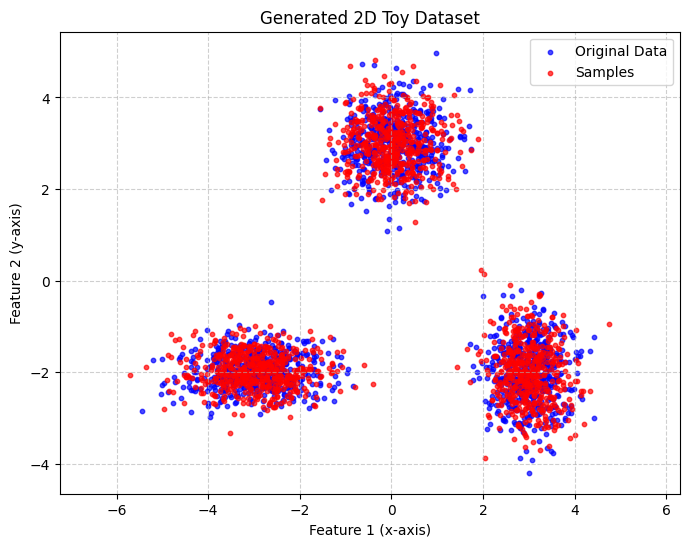

In [17]:
learn_spn_samples = sample(spn, 1500)

plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c='red', label='Samples')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()

To showcase conditional sampling and MPE we take a look at a dataset with more features.
Below, we load the digits dataset. This dataset contains 1797 8x8 images of digits 0 to 9.

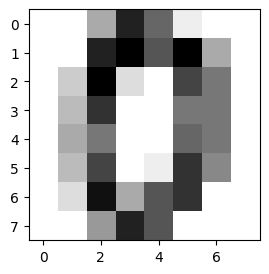

torch.Size([1797, 64])
tensor(0., dtype=torch.float32) tensor(16., dtype=torch.float32)


In [18]:
import matplotlib.pyplot as plt

from sklearn import datasets

# Load the digits dataset
digits = datasets.load_digits()

# Display the last digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

X = digits.data  # shape (1797, 64)
y = digits.target  # shape (1797,)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(X_tensor.shape)
print(X_tensor.min(), X_tensor.max())

In [19]:
from spflow.modules.leaf import Binomial

depth = 3
n_region_nodes = 5
num_leaves = 5
num_repetitions = 2
n_root_nodes = 1
num_feature = 64
n = torch.tensor(16) # total count for binomial distribution

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Binomial(scope=scope, n=n, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
rat

RatSPN(
  D=1, C=1, R=2
  (root_node): MixingLayer(
    D=1, C=1, R=2, weights=(1, 2, 1)
    (inputs): Sum(
      D=1, C=1, R=2, weights=(1, 25, 1, 2)
      (inputs): OuterProduct(
        D=1, C=25, R=2
        (inputs): ModuleList(
          (0): SplitHalves(
            D=2, C=5, R=2, dim=1
            (inputs): ModuleList(
              (0): Sum(
                D=2, C=5, R=2, weights=(2, 25, 5, 2)
                (inputs): OuterProduct(
                  D=2, C=25, R=2
                  (inputs): ModuleList(
                    (0): SplitHalves(
                      D=4, C=5, R=2, dim=1
                      (inputs): ModuleList(
                        (0): Sum(
                          D=4, C=5, R=2, weights=(4, 25, 5, 2)
                          (inputs): OuterProduct(
                            D=4, C=25, R=2
                            (inputs): ModuleList(
                              (0): SplitHalves(
                                D=8, C=5, R=2, dim=1
               

In [20]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

Time taken for epoch:  0.31099414825439453
Time taken for epoch:  0.2879946231842041
Time taken for epoch:  0.2890048027038574
Time taken for epoch:  0.28099489212036133
Time taken for epoch:  0.2800002098083496
Time taken for epoch:  0.28499937057495117
Time taken for epoch:  0.27800512313842773
Time taken for epoch:  0.270998477935791
Time taken for epoch:  0.2720010280609131
Time taken for epoch:  0.2709989547729492
Time taken for epoch:  0.2570035457611084
Time taken for epoch:  0.24199771881103516
Time taken for epoch:  0.2330009937286377
Time taken for epoch:  0.24099946022033691
Time taken for epoch:  0.2290034294128418
Time taken for epoch:  0.22699832916259766
Time taken for epoch:  0.2219991683959961
Time taken for epoch:  0.2120039463043213
Time taken for epoch:  0.21599650382995605
Time taken for epoch:  0.21600079536437988


Repetition idx: torch.Size([5, 1])
Samples shape before gather: torch.Size([5, 64, 5, 2])
torch.Size([5, 64])


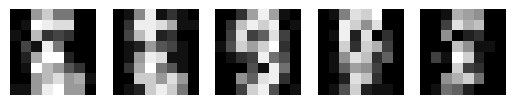

In [21]:
samples = sample(rat, 5)
print(samples.shape)

for i in range(5):
    img = samples[i].reshape(8, 8)  # reshape back to 2D
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

Repetition idx: torch.Size([1])
Samples shape before gather: torch.Size([1, 64, 5, 2])


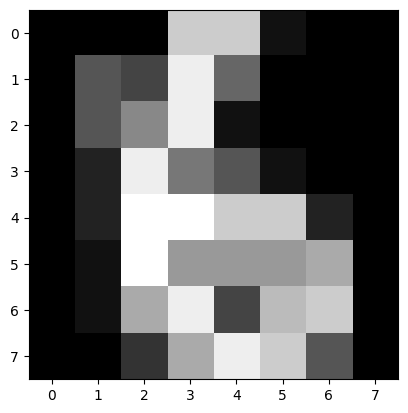

In [22]:
mpe = sample(rat,1, is_mpe=True)
plt.imshow(mpe.reshape(8,8), cmap="gray")
plt.show()

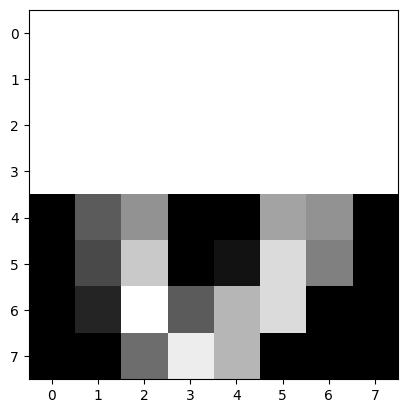

torch.Size([1, 64])
Repetition idx: torch.Size([1, 1, 1])
Samples shape before gather: torch.Size([1, 64, 5, 2])


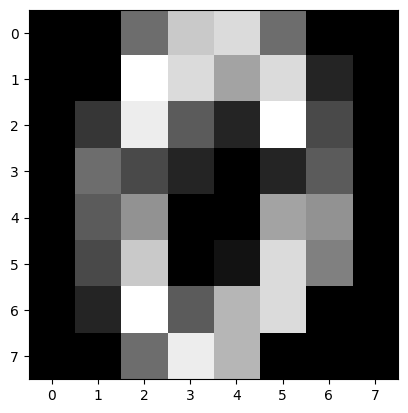

In [30]:
from spflow import sample_with_evidence
evidence = X_tensor[0]
evidence[:32] = torch.nan
plt.imshow(evidence.reshape(8,8), cmap="gray")
plt.show()
evidence = evidence.unsqueeze(0)
print(evidence.shape)
samples = sample_with_evidence(rat, evidence)
plt.imshow(samples.reshape(8,8), cmap="gray")
plt.show()
